In [1]:
import itertools
import pathlib

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import lab.metrics
import lab.analytics

sns.set_style("white")
plt.rcParams.update({
    'font.size': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8,
})

WITH_GRID = True

In [2]:
INPUTS = [
    f"../../results/ml-eval-conn/{path}/predict/{classifier}-0.csv"
    for classifier in ["kfp", "dfnet"]
    for path in ["front", "simulated-front", "undefended"]
    # for path in ["tamaraw", "simulated-tamaraw", "undefended"]
]
OUTPUT_FILE = pathlib.Path("/tmp/plot.png")
WITH_LEGEND = True
WITH_SIMULATED = True

if "snakemake" in globals():
    INPUTS = list(snakemake.input)
    OUTPUT_FILE = pathlib.Path(snakemake.output[0])
    WITH_LEGEND = snakemake.params.get("with_legend", False)
    WITH_SIMULATED = snakemake.params.get("with_simulated", True)

In [3]:
def _load_data(inputs):
    data = (pd.concat([
                pd.read_csv(fname, header=0) for fname in inputs
            ], keys=inputs, names=["path"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
            .astype({"y_true": int})
            .drop(columns=[-1])
            .assign(
                is_simulated=lambda x: x.index.get_level_values("path").str.contains("simulated"),
                defence=lambda x: x.index.get_level_values("path").map(
                    lambda s: next(defence for defence in ["front", "tamaraw", "undefended"] if defence in s)
                ),
                classifier=lambda x: x.index.get_level_values("path").map(
                    lambda s: next(classifier for classifier in ["kfp", "dfnet"] if classifier in s)
                ))
            .set_index(["defence", "classifier", "is_simulated"])
            .rename(index={"front": "FRONT", "tamaraw": "Tamaraw", "undefended": "Undefended",
                           "kfp": "$k$-FP", "dfnet": "DF"})
           )
    return data

data = _load_data(INPUTS)
data

y_true             0             1  \
defence    classifier is_simulated                                       
FRONT      $k$-FP     False             -1  0.000000e+00  0.000000e+00   
                      False             -1  0.000000e+00  0.000000e+00   
                      False             -1  0.000000e+00  0.000000e+00   
                      False             -1  0.000000e+00  0.000000e+00   
                      False             -1  0.000000e+00  0.000000e+00   
...                                    ...           ...           ...   
Undefended DF         False             99  3.944916e-10  1.683045e-08   
                      False             99  6.629246e-13  7.413063e-11   
                      False             99  9.155379e-13  6.314450e-11   
                      False             99  1.978863e-13  1.392045e-11   
                      False             99  1.390575e-11  4.554629e-10   

                                               2             3             4  \
defence    classifier is_simulated                                             
FRONT      $k$-FP     False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
...                                          ...           ...           ...   
Undefended DF         False         1.118144e-10  3.821821e-11  1.917898e-11   
                      False         2.353016e-13  4.325381e-14  9.981936e-14   
                      False         5.020542e-14  4.679588e-14  6.494288e-14   
                      False         1.801685e-14  3.763838e-14  5.286484e-14   
                      False         4.884498e-12  1.714777e-12  1.078738e-12   

                                               5             6             7  \
defence    classifier is_simulated                                             
FRONT      $k$-FP     False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
                      False         0.000000e+00  0.000000e+00  0.000000e+00   
...                                          ...           ...           ...   
Undefended DF         False         2.945400e-10  3.409049e-10  3.370604e-11   
                      False         1.748966e-13  3.635355e-13  4.258468e-14   
                      False         2.214484e-12  1.699296e-13  8.961288e-14   
                      False         1.089859e-13  1.332088e-13  1.178760e-14   
                      False         5.174767e-12  1.495037e-11  1.226745e-12   

                                               8  ...            90  \
defence    classifier is_simulated                ...                 
FRONT      $k$-FP     False         0.000000e+00  ...  0.000000e+00   
                      False         0.000000e+00  ...  0.000000e+00   
                      False         0.000000e+00  ...  0.000000e+00   
                      False         0.000000e+00  ...  0.000000e+00   
                      False         0.000000e+00  ...  0.000000e+00   
...                                          ...  ...           ...   
Undefended DF         False         7.548923e-10  ...  1.519129e-07   
                      False         8.712750e-13  ...  2.242854e-09   
                      False         7.201893e-13  ...  4.026993e-10   
                      False         1.219905e-13  ...  3.303160e-10   
                      False         2.114369e-11  ...  1.031806e-08   

                                              91            92     

In [4]:
def precision_recall_curve(df):
    return pd.DataFrame(lab.analytics.rprecision_recall_curve(
        df["y_true"], df.drop("y_true", axis=1), ratio=20
    )._asdict())

# def plot_pr_curve(data):
#     data = (data
#             .transform(lambda x: x*100)
#             .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
#             .rename({"precision": "$\pi_{20}$ (\%)", "recall": "Recall (\%)"}, axis=1)
#             .reset_index())
#     display(data)
# 
#     with plt.style.context([]):#"./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
#         grid = sns.relplot(
#             data=data, x="Recall (\%)", y="$\pi_{20}$ (\%)", hue="factor",
#             style="factor", col="classifier", kind="line", 
#             facet_kws=dict(legend_out=True, despine=False,
#                            gridspec_kws=dict(wspace=.1)),
#             palette="binary", legend=True
#         )
#         grid.set_titles(col_template="{col_name}")
#         
#         for i, ax in enumerate(np.ravel(grid.axes)):
#             # if i == 0:
#             #     ax.legend(labels=["Unmon.", "Control", "Both"])
#             ax.set_xticks([0, 50, 100])
#             ax.set_yticks([0, 50, 100])
#             ax.xaxis.get_major_formatter()._usetex = False
#             ax.yaxis.get_major_formatter()._usetex = False
#         
#     return grid

In [5]:
pr_scores = (data.groupby(["defence", "classifier", "is_simulated"])
             .apply(precision_recall_curve)
             .set_index("thresholds", append=True))
pr_scores

precision  recall
defence    classifier is_simulated     thresholds                   
FRONT      $k$-FP     False        0   0.000        0.016738  0.3515
                                   1   0.167        0.135175  0.2765
                                   2   0.333        0.135175  0.2765
                                   3   0.500        0.209892  0.2440
                                   4   0.667        0.433447  0.1905
...                                                      ...     ...
Undefended DF         False        466 0.996        0.716495  0.8340
                                   467 0.997        0.758701  0.8175
                                   468 0.998        0.773287  0.7845
                                   469 0.999        0.831832  0.6925
                                   470 1.000        1.000000  0.0025

[2396 rows x 2 columns]

In [6]:
pr_scores.index.unique("is_simulated")

Index([False, True], dtype='object', name='is_simulated')

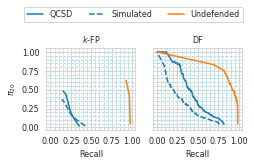

In [7]:
if WITH_GRID:
    sns.set_style("whitegrid")

def plot_pr_curves(plot_data):
    if not WITH_SIMULATED:
        plot_data = plot_data.xs(False, level="is_simulated", drop_level=False)
    
    fig, axes_arr = plt.subplots(1, 2, figsize=(3.5, 1.5), sharex=True, sharey=True)
    for classifier, axes in  zip(plot_data.index.unique("classifier"), axes_arr.ravel()):
        for defence, color in zip(plot_data.index.unique("defence"), ["#1f77b4", "#ff7f0e"]):
            for is_simulated, linestyle in zip([False, True], ["-", "--"]):
                if (
                    defence == "Undefended" and is_simulated
                    or is_simulated and not WITH_SIMULATED
                ):
                    continue
                
                label = "QCSD" if not is_simulated else "Simulated"
                # label = defence if defence == "Undefended" else f"{defence} ({label})"
                label = defence if defence == "Undefended" else label
                axes.plot(
                    plot_data["recall"][defence][classifier][is_simulated],
                    plot_data["precision"][defence][classifier][is_simulated],
                    label=label,
                    linestyle=linestyle,
                    color=color,
                )
        axes.set_xlabel("Recall")
        axes.set_xticks([0, .25, .5, .75, 1])
        
        if WITH_GRID:
            axes.grid(True, which="minor", axis="both", color="lightblue", linestyle="--")
            axes.yaxis.set_minor_locator(ticker.MultipleLocator(.05))
            axes.xaxis.set_minor_locator(ticker.MultipleLocator(.05))
        
        axes.set_title(classifier)
    axes_arr[0].set_ylabel("$\pi_{20}$")
    handles, labels = axes_arr[0].get_legend_handles_labels()
    if WITH_LEGEND:
        fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.02, 1.3), ncol=3)
    return fig

fig = plot_pr_curves(pr_scores)
fig.savefig(OUTPUT_FILE.with_suffix(".png"), bbox_inches="tight", dpi=150)
fig.savefig(OUTPUT_FILE.with_suffix(".pgf"), backend="pgf", bbox_inches="tight")